# Adversarial Robust Deep Hedging
#### Exploring the Heston Model
(Example 7.2)

In [1]:
from typing import Dict
from IPython import display
import numpy as np
import torch
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

import seaborn as sns
sns.set_theme()

from src.deep_hedging.DeepHedge import DeepHedgeConfig, DeepHedge
from src.deep_hedging.DeepHedgeHeston import DeepHedgeHeston, DeepHedgeHestonConfig
from src.deep_hedging.DeepHedgeTrainer import DeepHedgeTrainer, DeepHedgeTrainerConfig
from src.deep_hedging.StrategyNet import StrategyNetConfig
from src.deep_hedging.objectives.HedgeObjective import MeanVariance, Entropy, StableEntropy, Std
from src.derivative.EuropeanCallOption import EuropeanCallOption
from src.gan.RobustDhGan import RobustDhGan
from src.generator.HestonCoefficient import HestonCoefficientConfig, HestonDriftCoefficient, HestonDiffusionCoefficient
from src.generator.SdeGenerator import GeneratorConfig, SdeGenerator
from src.generator.HestonGenerator import HestonGenerator as TrainableHestonGenerator
from src.generator.SdeGeneratorTrainer import SdeGeneratorTrainerConfig
from src.penalty.Augmentations import LeadLag, AddTimeComponent
from src.penalty.SigWassersteinMetric import SignatureConfig, SigWassersteinMetric
from src.util.TimeUtil import UniformTimeDiscretization
from src.util.processes.BlackScholesGenerator import BlackScholesGenerator
from src.util.processes.BrownianMotionGenerator import BrownianMotionGenerator
from src.util.processes.HestonGenerator import HestonParameterSet, HestonGenerator
from src.util.torch_util.AdapterUtil import Adapter, AdapterList, SelectDimensions, ConvertToIncrements
from src.util.torch_util.TrainingUtil import TrainerConfig
from src.util.torch_util.CallbackUtil import PrintMetrics, PrintGeneratorParameters, PrintEmptyLine
from src.util.VisualizationUtil import QuantityLogger

In [2]:
torch.set_num_threads(10)

## Initialize

### Reference model and generator 

We begin by initializing the true market model. We choose the following paramters for demonstration. 

In [3]:
heston_parameters = HestonParameterSet(
    drift=0.0,
    reversion_level=0.04,
    reversion_speed=1,
    vol_of_vol=0.2,
    correlation=0.8,
)

Moreover, we need the following market parameters:

In [4]:
trading_freq: int = 5
td = UniformTimeDiscretization(trading_freq * 1. / 255., 90 // trading_freq)
derivative = EuropeanCallOption(strike=1.0, time_discretization=td, price=0.0)

This allows us to define a generator for the true underlying model: 

In [5]:
reference_generator = HestonGenerator(parameter=heston_parameters).provide_generator(
    initial_value=np.array([1.0, heston_parameters.reversion_level]),
    times=td.times,
    random_number_generator=np.random.default_rng(1111),
)

### Generate data with model uncertainty

We now generate `number_of_scenarios` scenarios, where we have a faulty `HestonParameterSet` given, that is obtained by calibration.

In [6]:
number_of_scenarios = 254

In [7]:
scenarios = [reference_generator(30) for _ in range(number_of_scenarios)]

### Define corresponding penalties

We can now initialize penalties that determine the distance to the generated paths in each scenario. 

In [8]:
pen_config = SignatureConfig(depth=2, augmentations=[AddTimeComponent(td), LeadLag()])
penalizers = [
    SigWassersteinMetric(scenario[:, :, 0:2], pen_config, transform=lambda x: 15000 * x) for scenario in scenarios
]

They measure the distance of generated paths by considering the distance to the heuristic volatility. 

In [9]:
reference_model_data = reference_generator(10000)[:, :, 0:2]
ref_pen = SigWassersteinMetric(reference_model_data[:, :, 0:2], pen_config, transform=lambda x: 1000 * x)

In [10]:
# distance_to_reference_model = [pen(reference_model_data) for pen in tqdm(penalizers)]

In [11]:
# fig, axs = plt.subplots(1, 1, figsize=(5,3))
# axs.hist(distance_to_reference_model, bins=41)
# plt.tight_layout()
# plt.show()

### Initialize generators

With this, we can now initialize an `SdeGenerator` that has `BlackScholesCoefficient` corresponding to the above estimates. 

Note that formally these would be calibrated to the data in this step, but we omit this, since the result is obviously equivalent. 

In [12]:
generators = []
for _ in penalizers:
    coef_config = HestonCoefficientConfig(heston_parameters, initial_asset_price=1.0)
    drift_coef, diffusion_coef = HestonDriftCoefficient(coef_config), HestonDiffusionCoefficient(coef_config)
    gen_config = GeneratorConfig(td, drift_coef.get_initial_asset_price, drift_coef, diffusion_coef)
    generators.append(TrainableHestonGenerator(generator_config=gen_config))

We disable the training for all drift parameters:

In [13]:
for g in generators:
    g.drift.drift.requires_grad = False

### Noise Generator
In order to utilize the generator, we require a noise generator. In this case, this is a simple Brownian motion generator:

In [14]:
noise_generator = BrownianMotionGenerator().provide_increment_generator(
    initial_value=np.zeros(2),
    times=td.times,
    random_number_generator=np.random.default_rng(4444),
)

### Fitting the generators

In [15]:
losses_for_scenarios = []

for j in tqdm(range(number_of_scenarios)):
    g = generators[j]
    p = penalizers[j]
    
    try:
        g.load_state_dict(torch.load(f'resources/network-states/h_test/generator_{j}.pt'))
        
    except FileNotFoundError:
        gen_optimizer = torch.optim.Adam(g.parameters()) # , lr=1e-4
        gen_scheduler = torch.optim.lr_scheduler.StepLR(gen_optimizer, step_size=5, gamma=0.9)

        # para_list = [[], [], [], [], [], []]

        # hdisplay = display.display("", display_id=True)
        # fig, axs = plt.subplots(1,6,figsize=(18, 3))
        losses = QuantityLogger()
        pbar = tqdm(list(range(100)), leave=False)
        for i in pbar:
            noise = noise_generator(10000)

            output = g(noise)[:, :, 0:2]
            loss = p(output)
            g.zero_grad()
            loss.backward()
            gen_optimizer.step()
            gen_scheduler.step()

            losses.update(loss.item())
            pbar.set_postfix({'Loss': losses.average_since_mark})

            # names = ['loss'] + [f"{n.split('.')[-1]}" for n, _ in g.named_parameters()]

            # para_list[0].append(loss.item())
            # for l, v in zip(para_list[1:], dict(g.named_parameters()).values()):
            #     l.append(v.detach().item())

            #     # print(len(para_list[0]))
            # if i % 1 == 0:
            #     for j in range(6):
            #         axs[j].plot(i, para_list[j][i], 'o', ms=2)
            #         axs[j].set_title(names[j])
            #     plt.tight_layout()
            #     # plt.show()
            #     hdisplay.update(fig)

        torch.save(g.state_dict(), f'resources/network-states/h_test/generator_{j}.pt') 
        losses_for_scenarios.append(losses)

In [16]:
parameter_sets = [
    HestonParameterSet(
        heston_parameters.drift,
        reversion_level=g.drift.reversion_level.item(),
        reversion_speed=g.drift.reversion_speed.item(),
        vol_of_vol=g.diffusion.vol_of_vol.item(),
        correlation=g.diffusion.correlation.item(),
    ) for g in generators
]

In [17]:
distance_to_ref = [
    SigWassersteinMetric(
        g(noise_generator(10000))[:, :, 0:2],
        pen_config,
        transform=lambda x: 15000 * x
    )(reference_model_data).item() for scenario in tqdm(scenarios)
]

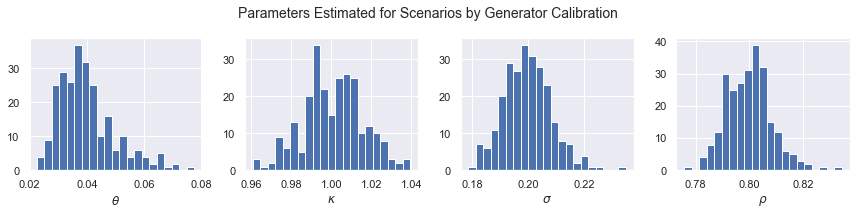

In [18]:
fig, axs = plt.subplots(1,4,figsize=(12,3))
axs[0].hist([ps.reversion_level for ps in parameter_sets], bins=21)
axs[0].set_xlabel(r'$\theta$')
axs[1].hist([ps.reversion_speed for ps in parameter_sets], bins=21)
axs[1].set_xlabel(r'$\kappa$')
axs[2].hist([ps.vol_of_vol for ps in parameter_sets], bins=21)
axs[2].set_xlabel(r'$\sigma$')
axs[3].hist([ps.correlation for ps in parameter_sets], bins=21)
axs[3].set_xlabel(r'$\rho$')
plt.suptitle("Parameters Estimated for Scenarios by Generator Calibration", fontsize=14)
plt.tight_layout()
# plt.savefig('figs/HestonParameters.pdf')
plt.show()

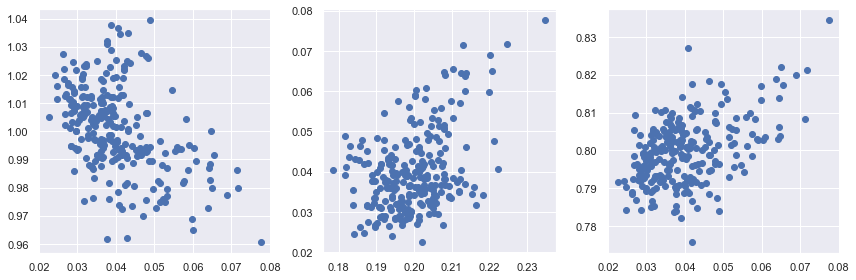

In [19]:
fig, axs = plt.subplots(1,3,figsize=(12,4))
axs[0].scatter([ps.reversion_level for ps in parameter_sets], [ps.reversion_speed for ps in parameter_sets])
axs[1].scatter([ps.vol_of_vol for ps in parameter_sets], [ps.reversion_level for ps in parameter_sets])
axs[2].scatter([ps.reversion_level for ps in parameter_sets], [ps.correlation for ps in parameter_sets])
plt.tight_layout()
plt.show()

### Test data generation

In [25]:
arbitrary_test_data = generators[0](noise_generator(100)).detach().numpy()
arbitrary_reference_data = reference_generator(100)

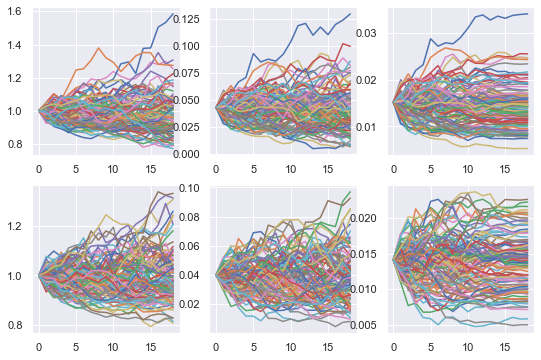

In [26]:
fig, axs = plt.subplots(2, 3, figsize=(9, 6))
for i in range(3):
    axs[0, i].plot(arbitrary_test_data[:, :, i].T)
    axs[1, i].plot(arbitrary_reference_data[:, :, i].T)
plt.show()

## Deep Hedging

We will now train a deep hedge on each of the individual models. This has tow purposes

1. we use these deep hedges as pre-trained components for the actual application of the robust hedge GAN, and
2. we will use these hedges to compare the robust hedge GAN on out-of-sample generated data against.

### Initialization 

We begin by setting a hedging objective, since it remains the same over all models. 

In [27]:
hedge_objective = MeanVariance(84)

Next, we define the deep hedges.

In [28]:
deep_hedges = []
for ps in parameter_sets:
    strategy_config = StrategyNetConfig(dimension_of_asset=2, number_of_layers=3, nodes_in_intermediate_layers=36)
    initial_asset_price_for_deep_hedge = torch.tensor([
        1.0,
        ps.reversion_level,
        HestonGenerator(parameter=ps).get_correction_term(td.maturity, ps.reversion_level)
    ], dtype=torch.float32)
    deep_hedges.append(DeepHedgeHeston(DeepHedgeHestonConfig(derivative, initial_asset_price_for_deep_hedge, strategy_config)))

### Pretraining Deep Hedge

In [29]:
coef_config = HestonCoefficientConfig(heston_parameters, initial_asset_price=1.0)
drift_coef, diffusion_coef = HestonDriftCoefficient(coef_config), HestonDiffusionCoefficient(coef_config)
gen_config = GeneratorConfig(td, drift_coef.get_initial_asset_price, drift_coef, diffusion_coef)
ref_gen = TrainableHestonGenerator(generator_config=gen_config)

In [30]:
strategy_config = StrategyNetConfig(dimension_of_asset=2, number_of_layers=3, nodes_in_intermediate_layers=36)
initial_asset_price_for_deep_hedge = torch.tensor([
    1.0,
    ps.reversion_level,
    HestonGenerator(parameter=heston_parameters).get_correction_term(td.maturity, ps.reversion_level)
], dtype=torch.float32)
dh = DeepHedgeHeston(DeepHedgeHestonConfig(derivative, initial_asset_price_for_deep_hedge, strategy_config))

In [31]:
sample_size = 50000
batch_sizes_for_epoch = [100]*5 + [1000]*3

In [32]:
try:
    dh.load_state_dict(torch.load(f'resources/network-states/h_test/pre_trained_dh.pt'))
except FileNofFoundError():
    generated = ConvertToIncrements()(ref_gen(noise_generator(sample_size)).detach())
    opt = torch.optim.Adam(dh.parameters())

    losses = QuantityLogger()
    bbar = tqdm(batch_sizes_for_epoch, leave=False)
    for batch_size in bbar:
        losses.set_mark()
        pbar = tqdm(
            [generated[bno:min(bno + batch_size, sample_size)] for bno in range(0, sample_size, batch_size)],
            leave=False,
        )
        for batch in pbar:
            pnl = dh(batch)
            loss = hedge_objective(pnl)
            dh.zero_grad()
            loss.backward()
            opt.step()

            losses.update(loss.item())
            pbar.set_postfix({'Loss': losses.average_since_mark})

        bbar.set_postfix({'Loss': losses.average_since_mark})


    torch.save(dh.state_dict(), f'resources/network-states/h_test/pre_trained_dh.pt') 

### Training

We will now train each individual hedge on the corresponding generator. For this we will use 

In [33]:
sample_size = 50000
batch_sizes_for_epoch = [1000]*3

In [34]:
losses_for_scenarios = []

for i, dh in tqdm(enumerate(deep_hedges), total=number_of_scenarios):
    
    try:
        dh.load_state_dict(torch.load(f'resources/network-states/h_test/scenario_{i}.pt'))
        
    except FileNotFoundError:
        dh.load_state_dict(torch.load(f'resources/network-states/h_test/pre_trained_dh.pt'))
        
        dh.train()
        generated = ConvertToIncrements()(generators[i](noise_generator(sample_size)).detach())
        opt = torch.optim.Adam(dh.parameters())

        losses = QuantityLogger()
        bbar = tqdm(batch_sizes_for_epoch, leave=False)
        for batch_size in bbar:
            losses.set_mark()
            pbar = tqdm(
                [generated[bno:min(bno + batch_size, sample_size)] for bno in range(0, sample_size, batch_size)],
                leave=False,
            )
            for batch in pbar:
                pnl = dh(batch)
                loss = hedge_objective(pnl)
                dh.zero_grad()
                loss.backward()
                opt.step()

                losses.update(loss.item())
                pbar.set_postfix({'Loss': losses.average_since_mark})

            bbar.set_postfix({'Loss': losses.average_since_mark})

            
        torch.save(dh.state_dict(), f'resources/network-states/h_test/scenario_{i}.pt') 
        losses_for_scenarios.append(losses)


### Testing

In [35]:
reference_generator = HestonGenerator(parameter=heston_parameters).provide_generator(
    initial_value=np.array([1.0, heston_parameters.reversion_level]),
    times=td.times,
    random_number_generator=np.random.default_rng(1111),
)
test_data = torch.diff(reference_generator(10000), 1, 1)

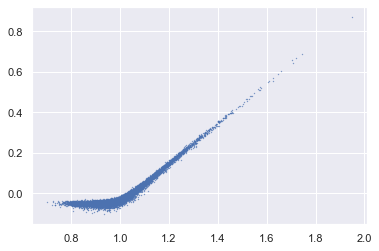

In [36]:
deep_hedges[0].eval()
deep_hedge_results = np.sum(deep_hedges[0](test_data).detach().numpy() * test_data.numpy()[:, :, (0,2)], axis=(1))
terminal_values_on_test = np.sum(test_data.numpy(), axis=(1))[:, 0] + 1.0
plt.scatter(terminal_values_on_test, np.sum(deep_hedge_results, axis=1), s=.1)
# plt.scatter(terminal_values_on_test, derivative.payoff_for_terminal_asset_values(torch.sum(test_data, dim=1) + 1), s=.1)
deep_hedges[0].train()
plt.show()

In [37]:
oosp = [hedge_objective(dh(test_data)).item() for dh in tqdm(deep_hedges)]

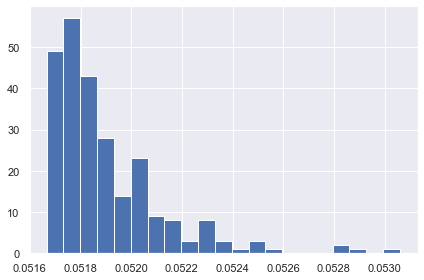

In [38]:
plt.hist(oosp, bins=21)
plt.tight_layout()
plt.show()

## Robust Hedge GAN

In [39]:
batch_size = 10000
number_of_batches = 50
batches = [noise_generator(batch_size) for _ in range(number_of_batches)]

In [40]:
hedge_losses_for_scenarios = []
generation_losses_for_scenarios = []

for i in tqdm(range(number_of_scenarios)):
    
    dh = deep_hedges[i]
    h_opt = torch.optim.Adam(dh.parameters())
    h_scheduler = torch.optim.lr_scheduler.StepLR(h_opt, step_size=100)
    h_adapter = ConvertToIncrements()
    
    g = generators[i]
    g_opt = torch.optim.Adam(g.parameters())
    g_scheduler = torch.optim.lr_scheduler.StepLR(g_opt, step_size=100)
    
    p = penalizers[i]
    p_adapter = SelectDimensions(dims=(0,1))
    
    try:
        dh.load_state_dict(torch.load(f'resources/network-states/h_test/gan_scenario_{i}.pt'))
        
    except FileNotFoundError:
        
        dh.train()
        
        h_losses = QuantityLogger()
        g_losses = QuantityLogger()
        
        pbar = tqdm(batches)
        for batch in pbar:
            # Update discriminator
            ## Forward pass
            generated = g(batch)
            profit_and_loss = dh(h_adapter(generated))
            hedge_loss = hedge_objective(profit_and_loss)
            ## Backward pass
            dh.zero_grad()
            hedge_loss.backward()
            h_opt.step()
            h_scheduler.step()
            h_losses.update(hedge_loss.item())

            # Update generator
            ## Forward pass
            generated = g(batch)
            profit_and_loss = dh(h_adapter(generated))
            hedge_loss = hedge_objective(profit_and_loss)
            penalty = p(p_adapter(generated))
            generation_loss = penalty - hedge_loss
            ## Backward pass
            g.zero_grad()
            generation_loss.backward()
            g_opt.step()
            g_scheduler.step()
            g_losses.update(generation_loss.item())
            
            pbar.set_postfix({
                'GLoss': g_losses.average,
                'HLoss': h_losses.average,
                'Penal': penalty.item(),
                'Spe': g.drift.reversion_speed.item(),
                'Lev': g.drift.reversion_level.item(),
                'VoV': g.diffusion.vol_of_vol.item(),
                'Cor': g.diffusion.correlation.item(),
            })
        
        torch.save(dh.state_dict(), f'resources/network-states/h_test/gan_scenario_{i}.pt') 
        hedge_losses_for_scenarios.append(h_losses)
        generation_losses_for_scenarios.append(g_losses)

In [41]:
oosp_robust = [hedge_objective(dh(test_data)).item() for dh in tqdm(deep_hedges)]

In [42]:
print('Naive:  ', np.mean(oosp))
print('Robust: ', np.mean(oosp_robust))
print()
print('Naive:  ', np.std(oosp))
print('Robust: ', np.std(oosp_robust))

Naive:   0.0518985178145602
Robust:  0.051817819314796155

Naive:   0.00022192681188724776
Robust:  0.0001924120542635965


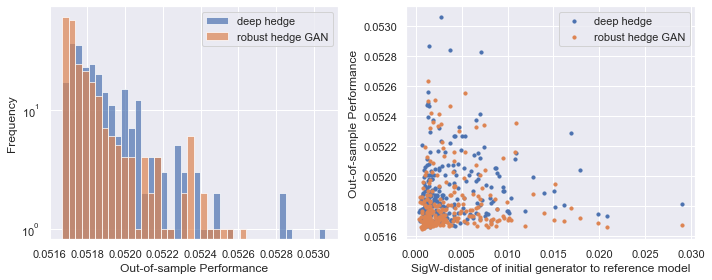

In [43]:
fig, axs = plt.subplots(1, 2, figsize = (10, 4))

vals_n, bins = np.histogram(oosp, bins=40)
vals_r = np.histogram(oosp_robust, bins=bins)[0]
bin_centers = 0.5*(bins[1:]+bins[:-1])
axs[0].hist(oosp, bins=bins, label='deep hedge', color='C0', alpha=.7)
axs[0].hist(oosp_robust, bins=bins, label='robust hedge GAN', color='C1', alpha=.7)
axs[0].set_xlabel('Out-of-sample Performance')
axs[0].set_ylabel('Frequency')
axs[0].set_yscale('log')
axs[0].legend()
# axs[0].set_title('')

axs[1].scatter(distance_to_ref, oosp, label='deep hedge', s=10)
axs[1].scatter(distance_to_ref, oosp_robust, label='robust hedge GAN', s=10)
axs[1].set_xlabel('SigW-distance of initial generator to reference model')
axs[1].set_ylabel('Out-of-sample Performance')
axs[1].legend()
# axs[1].set_title()

plt.tight_layout()
plt.savefig('figs/HestonRobustification.pdf')
plt.show()

In [44]:
import mpl_axes_aligner

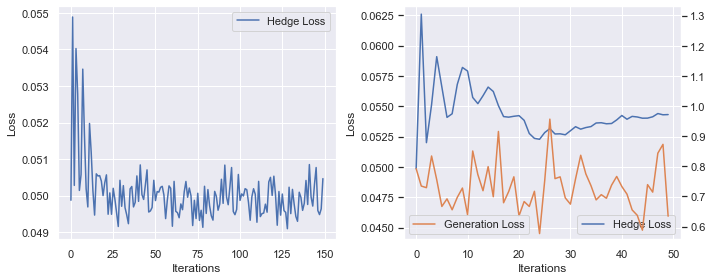

In [45]:
fig, axs = plt.subplots(1, 2, figsize = (10, 4))

axs[0].plot(losses.history, label='Hedge Loss')
axs[0].set_xlabel('Iterations')
axs[0].set_ylabel('Loss')
axs[0].legend()
# axs[0].set_title()

axs[1].plot(h_losses.history, c='C0', label='Hedge Loss')
axs[1].set_xlabel('Iterations')
axs[1].set_ylabel('Loss')
# axs[1].set_title('')

axs_clone = axs[1].twinx()
axs_clone.plot(g_losses.history, c='C1', label='Generation Loss', ls='-')# , marker='x'

axs[1].legend(loc='lower right')
axs_clone.legend(loc='lower left')

axs_clone.grid(False)

mpl_axes_aligner.align.yaxes(axs[1], h_losses.history[0], axs_clone, g_losses.history[0])

plt.tight_layout()
# plt.savefig('figs/HestonLossCurve.pdf')
plt.show()